In [36]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale images
])

train_dataset = datasets.MNIST(root='/kaggle/working/mnist-data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/kaggle/working/mnist-data', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [38]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [39]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
print(mnist_dim)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

784


In [40]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [41]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [42]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [43]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [44]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [79]:
n_epoch = 20
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/20]: loss_d: 1.198, loss_g: 1.020
[2/20]: loss_d: 1.203, loss_g: 1.018
[3/20]: loss_d: 1.200, loss_g: 1.018
[4/20]: loss_d: 1.202, loss_g: 1.016
[5/20]: loss_d: 1.211, loss_g: 1.003
[6/20]: loss_d: 1.208, loss_g: 1.019
[7/20]: loss_d: 1.223, loss_g: 0.992
[8/20]: loss_d: 1.223, loss_g: 0.983
[9/20]: loss_d: 1.222, loss_g: 0.979
[10/20]: loss_d: 1.220, loss_g: 0.989
[11/20]: loss_d: 1.222, loss_g: 0.978
[12/20]: loss_d: 1.225, loss_g: 0.999
[13/20]: loss_d: 1.221, loss_g: 0.996
[14/20]: loss_d: 1.229, loss_g: 0.969
[15/20]: loss_d: 1.229, loss_g: 0.965
[16/20]: loss_d: 1.232, loss_g: 0.965
[17/20]: loss_d: 1.227, loss_g: 0.979
[18/20]: loss_d: 1.227, loss_g: 0.981
[19/20]: loss_d: 1.233, loss_g: 0.966
[20/20]: loss_d: 1.247, loss_g: 0.942


In [82]:
n_epoch = 20
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/20]: loss_d: 1.236, loss_g: 0.955
[2/20]: loss_d: 1.245, loss_g: 0.944
[3/20]: loss_d: 1.242, loss_g: 0.955
[4/20]: loss_d: 1.240, loss_g: 0.949
[5/20]: loss_d: 1.239, loss_g: 0.964
[6/20]: loss_d: 1.242, loss_g: 0.944
[7/20]: loss_d: 1.239, loss_g: 0.967
[8/20]: loss_d: 1.237, loss_g: 0.959
[9/20]: loss_d: 1.248, loss_g: 0.934
[10/20]: loss_d: 1.250, loss_g: 0.934
[11/20]: loss_d: 1.250, loss_g: 0.941
[12/20]: loss_d: 1.256, loss_g: 0.923
[13/20]: loss_d: 1.259, loss_g: 0.916
[14/20]: loss_d: 1.258, loss_g: 0.928
[15/20]: loss_d: 1.267, loss_g: 0.912
[16/20]: loss_d: 1.253, loss_g: 0.940
[17/20]: loss_d: 1.247, loss_g: 0.939
[18/20]: loss_d: 1.263, loss_g: 0.919
[19/20]: loss_d: 1.267, loss_g: 0.902
[20/20]: loss_d: 1.268, loss_g: 0.908


In [77]:
# Save the trained generator and discriminator models
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')
print("Models have been saved.")


Models have been saved.


In [78]:
!zip -r outMyGan.zip ./

updating: generator.pth (deflated 7%)
updating: .virtual_documents/ (stored 0%)
updating: generated_grid.png (deflated 7%)
updating: mnist-data/ (stored 0%)
updating: mnist-data/MNIST/ (stored 0%)
updating: mnist-data/MNIST/raw/ (stored 0%)
updating: mnist-data/MNIST/raw/train-labels-idx1-ubyte (deflated 52%)
updating: mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz (stored 0%)
updating: mnist-data/MNIST/raw/train-images-idx3-ubyte.gz (deflated 0%)
updating: mnist-data/MNIST/raw/train-images-idx3-ubyte (deflated 79%)
updating: mnist-data/MNIST/raw/t10k-labels-idx1-ubyte (deflated 55%)
updating: mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz (deflated 0%)
updating: mnist-data/MNIST/raw/t10k-images-idx3-ubyte (deflated 79%)
updating: mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz (stored 0%)
updating: discriminator.pth (deflated 7%)


In [30]:
# Load the trained generator and discriminator models
# G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
# D = Discriminator(d_input_dim=mnist_dim).to(device)

# # Load the saved state dictionaries
# G.load_state_dict(torch.load('generator.pth'))
# D.load_state_dict(torch.load('discriminator.pth'))
# print("Models have been loaded.")


Models have been loaded.


/tmp/ipykernel_30/2005357460.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator.pth'))
/tmp/ipykernel_30/2005357460.py:7: FutureWarn

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')

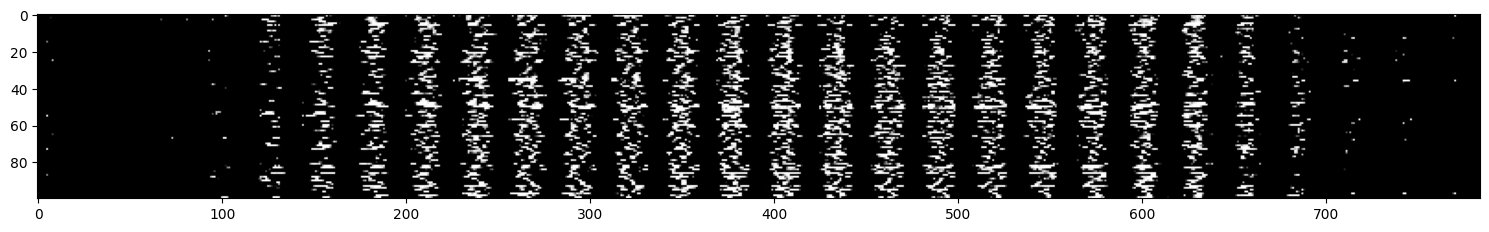

In [80]:
import torch
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot to use for displaying images

# Assuming bs, z_dim, and device are defined elsewhere, and G is your generator model

# Generate a batch of images (assuming bs > 1 for a batch)
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))  # Random noise
    generated = G(test_z)  # Generate a batch of images

    # Create a grid of generated images (in case you generate multiple images)
    grid_image = vutils.make_grid(generated, nrow=8, normalize=False, scale_each=True)

    # Display the grid of images using matplotlib
    plt.figure(figsize=(15,15))  # Set the size of the figure
    plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # permute to HWC for display

#     plt.axis('off')  # Hide axes for a cleaner view
    plt.tight_layout()

    plt.show()
    
    # Normalize grid_image to [0, 1] range
    grid_image = (grid_image - grid_image.min()) / (grid_image.max() - grid_image.min())

    # Save the normalized image
    plt.imsave("generated_grid.png", grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')

torch.Size([100, 100])
torch.Size([100, 784])


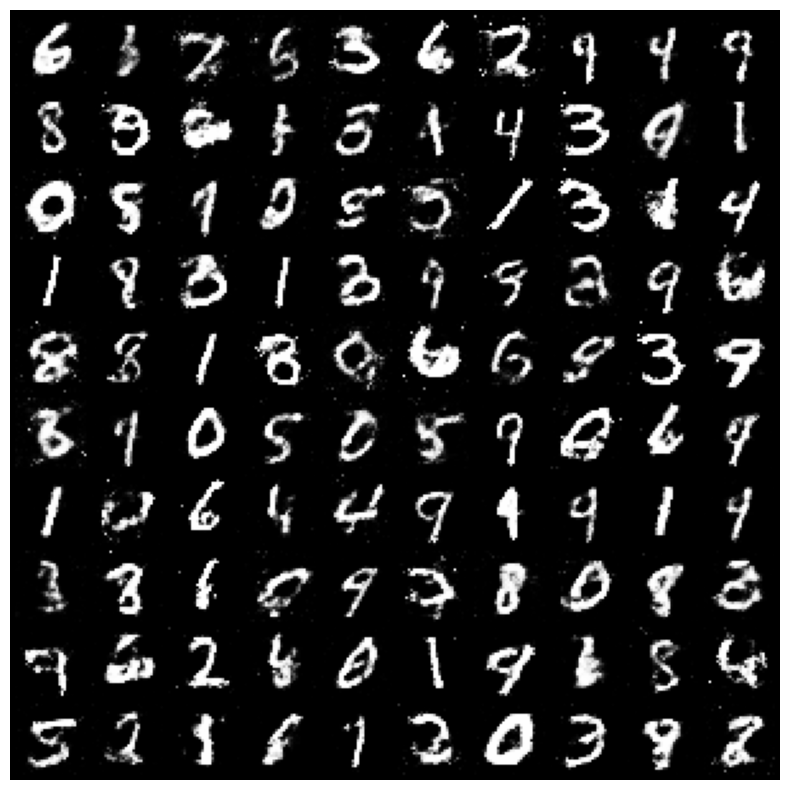

In [81]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    print(test_z.shape)
    generated = G(test_z)  # Generate images
    print(generated.shape)
    
    # Reshape the generated images to (batch_size, 1, 28, 28) to match the second code
    generated = generated.view(generated.size(0), 1, 28, 28)
    
    # Create a grid of generated images
    grid_image = vutils.make_grid(generated, nrow=10, normalize=True, scale_each=True)
    
    # Display the grid of images using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Save the grid image
    plt.imsave("generated_grid.png", grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')

100
torch.Size([100, 100])
torch.Size([100, 784])


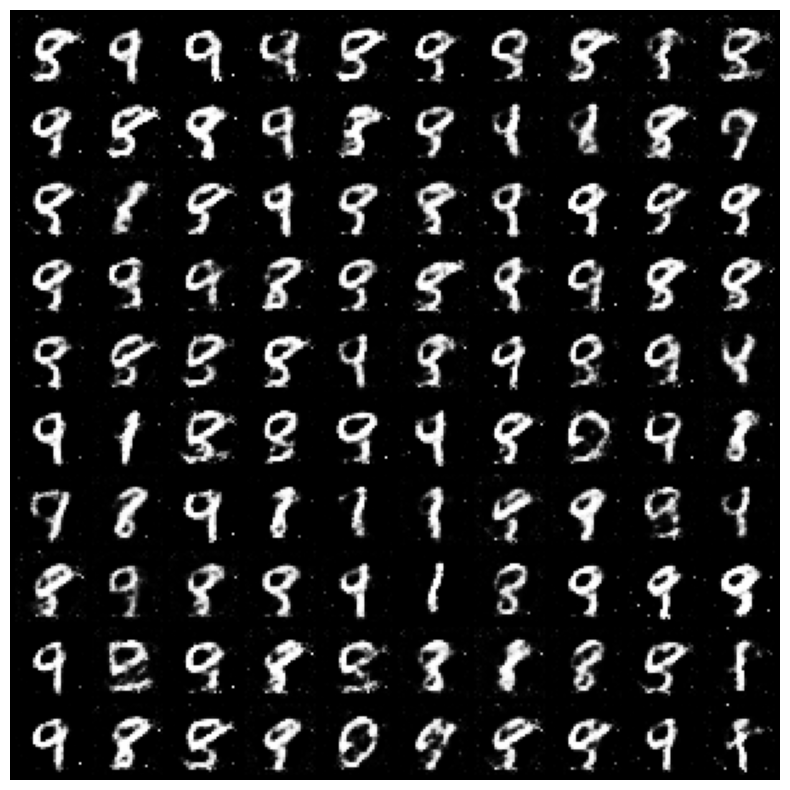

In [85]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torchvision.utils as vutils
import os
import re

# Define the batch size, z_dim, and device (CPU or GPU)
batch_size = 100  # Example batch size
z_dim = 100  # Size of the latent vector expected by the GAN (this may change depending on your model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example: Let's assume you have 16 noisy PNG images
image_dir = '/kaggle/input/mnist-ddpm-noise-sampled/samples3'  # Directory where the noisy PNG images are located

# Define the transformation to apply to the images (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((10, 10)),  # Resize to 28x28 if the model expects 28x28 images
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are grayscale (if needed)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to [-1, 1]
])

# Load noisy images from the directory
# image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
pattern = r'^x0_0_\d+\.png$'  # Match 'x0_0_' followed by one or more digits, then '.png'

# Use list comprehension to get all files that match the pattern
image_files = [f for f in os.listdir(image_dir) if re.match(pattern, f)]
# image_files = image_files[:batch_size]  # Limit to batch_size
print(len(image_files))

images = []
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB if needed
    img = transform(img)  # Apply the transformations
    images.append(img)

# Stack the images to form a batch
input_images = torch.stack(images).to(device)  # Shape: [batch_size, 1, 28, 28]
input_images = input_images.view(batch_size, -1)  # Flatten the images

print(input_images.shape)
# Feed the images into the generator
with torch.no_grad():
    generated = G(input_images)  # Generate new images from the noisy input images
    print(generated.shape)
    generated = generated.view(generated.size(0), 1, 28, 28)


    # Create a grid of generated images
    grid_image = vutils.make_grid(generated, nrow=10, normalize=True, scale_each=True)

    # Display the grid of images using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

    #Save the grid image
    plt.imsave("generated_grid.png", grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')


In [9]:
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['mnist-ddpm-noise-sampled', 'mymnist']
/kaggle/input/mnist-ddpm-noise-sampled ['samples3']
/kaggle/input/mnist-ddpm-noise-sampled/samples3 []
/kaggle/input/mymnist ['samples', 'mnist_data']
/kaggle/input/mymnist/samples []
/kaggle/input/mymnist/mnist_data ['processed', 'raw']
/kaggle/input/mymnist/mnist_data/processed []
/kaggle/input/mymnist/mnist_data/raw []
